# Tutorial

EQTransformer package is divided into two main sub-modules, the core and utils sub-modules.

The core sub-module contains the main, high-level functions:

trainer:	It can be used to generate and train new EQTransformer models with different encoder depths.
tester:	It is used to test a trained model using ground truth data.
predictor:	It is used to apply a pre-trained model to pre-processed continuous data.
mseed_predictor:
 	It is used to perform a fast detection & picking directly on continuous data in MiniSeed format.
The utils sub-module contains the main, high-level functions:

downloader:	It can be used to download continuous data from seismic networks.
hdf5_maker:	It is used to pre-process the continuous data and slice it to 1-minute windows used by predictor module.
plot:	It contains a few different methods to visualize the detection and downloading results.
associator:	Performs a simple phase association and output phase information for the associated events in HypoInverse input format.

## Downloading Continuous Data

The following will download the information on the stations that are available based on your search criteria:

In [ ]:
import os
json_basepath = os.path.join(os.getcwd(),"json/station_list.json")

from EQTransformer.utils.downloader import makeStationList

makeStationList(json_path=json_basepath, client_list=["SCEDC"], min_lat=35.50, max_lat=35.60, min_lon=-117.80, max_lon=-117.40, start_time="2019-09-01 00:00:00.00", end_time="2019-09-03 00:00:00.00", channel_list=["HH[ZNE]", "HH[Z21]", "BH[ZNE]"], filter_network=["SY"], filter_station=[])

The above function will generate station_list.json file containing the station information. Next, you can use this file and download 1 day of data for the available stations at Ridgecrest, California from Southern California Earthquake Data Center or IRIS using the following:

In [ ]:
from EQTransformer.utils.downloader import downloadMseeds

downloadMseeds(client_list=["SCEDC", "IRIS"], stations_json=json_basepath, output_dir="downloads_mseeds", min_lat=35.50, max_lat=35.60, min_lon=-117.80, max_lon=-117.40, start_time="2019-09-01 00:00:00.00", end_time="2019-09-03 00:00:00.00", chunk_size=1, channel_list=[], n_processor=2)

This will download the continous data (in MiniSeed) and save them into individual folders for each station insider your defined output directory (i.e. downloads_mseeds).

Check the downloading.ipynb or API Documentations for more details.

## Detection and Picking

To perform detection & picking you need a pre-trained model of EQTransformer which you can get from ModelsAndSampleData.

EQTransformer provides two different option for performing the detection & picking on the continuous data:

Option (I) using pre-processed data (hdf5 files):
This option is recommended for smaller periods (a few days to a month). This allows you to test the performance and explore the effects of different parameters while the provided hdf5 file makes it easy to access the waveforms.

For this option, you first need to convert your MiniSeed files for each station into 1-min long Numpy arrays in a single hdf5 file and generated a CSV file containing the list of traces in the hdf5 file. You can do this using the following command:

In [ ]:
from EQTransformer.utils.hdf5_maker import preprocessor

preprocessor(preproc_dir="preproc", mseed_dir='downloads_mseeds', stations_json=json_basepath, overlap=0.3, n_processor=2)

This will generate one station_name.hdf5 and one station_name.csv file for each of your station’s data and put them into a directory named mseed_dir+_hdfs. Then you need to pass the name of this directory (which contains all of your hdf5 & CSV files) and a model to the following command:

In [ ]:
from EQTransformer.core.predictor import predictor

predictor(input_dir= 'downloads_mseeds_processed_hdfs', input_model='EqT_model.h5', output_dir='detections', detection_threshold=0.3, P_threshold=0.1, S_threshold=0.1, number_of_plots=100, plot_mode='time')

You can use relatively low threshold values for the detection and picking since EQTransformer is robust to false positives. Note that enabling uncertainty estimation, outputting probabilities, or plotting all the detected events will slow down the process.

Outputs for each station will be written in your output directory (i.e. detections).

X_report.txt contains the processing info on input parameters used for the detection &picking and final results such as running time, the total number of detected events (these are unique events and duplicated ones have been already removed).

X_prediction_results.csv contains detection & picking results.

In the figures folder, you can find the plots for some detected events:
    These plots are helpful to check if you are getting too many false positives (non-earthquake signals) and get a better sense that if your selected threshold values for the detection and picking is too high or too low.

If you are using local MiniSeed files you can generate a station_list.json by supplying an absolute path to a directory containing Miniseed files and a station location dictionary using the stationListFromMseed function like the following:

Option (II) directly from mseed files:
You can perform the detection & phase picking directly on downloaded MiniSeed files. This saves both preprocessing time and the extra space needed for the hdf5 file and is recommended for larger (longer) datasets. However, it can be more memory intensive. So it is better to have your MiniSeed fils being shorter than one month or so.

This option also does not allow you to estimate the uncertainties, save the prediction probabilities, or use the advantages of having hdf5 files which makes it easy to access the raw event waveforms based on detection results.

## Visualizing the Results

### Continouty of the Seismic Data Being Processed:
Both prepocessor and mseed_predictor output a time_tracks.pkl file that contains the time info of original data and their number of components. You can use this file to visualize the continuity and type of your data using the following module:

In [ ]:
from EQTransformer.utils.plot import plot_data_chart

plot_data_chart('time_tracks.pkl', time_interval=10)

### Helicorder Plots:
To check if you are missing too many events (high false negative) in the continuous data or catch most of them, it is always a good idea to check out the raw data (the most important lesson in observational seismology). You can do it using these commands:

First, you can check one particular day of (raw) data:

In [ ]:
from EQTransformer.utils.plot import plot_detections, plot_helicorder

plot_helicorder(input_mseed='downloads_mseeds/CA06/GS.CA06.00.HHZ__20190902T000000Z__20190903T000000Z.mseed', input_csv=None)

Now the following command will mark those events that you have detected on your helicorder plot:

In [ ]:
plot_helicorder(input_mseed='downloads_mseeds/CA06/GS.CA06.00.HHZ__20190902T000000Z__20190903T000000Z.mseed', input_csv='detections/CA06_outputs/X_prediction_results.csv')

## Phase Association

After detection, the following performs a simple and fast association and writes down the results in HypoInverse format (Y2000.phs) and ObsPy QuakeML format (associations.xml) which can directly be used to locate the detected earthquakes using conventional location algorithms like HypoInverse or NonLinLoc. This also outputs traceName_dic.json, a dictionary where the trace names for source waveforms of all the detections associated with an event are listed. This can be used later to access the original waveform traces for calculating the cross-correlations during the relocation process or magnitude estimation.

In [ ]:
import shutil
import os
from EQTransformer.utils.associator import run_associator

out_dir = "asociation"
try:
        shutil.rmtree(out_dir)
except Exception:
        pass
os.makedirs(out_dir)

run_associator(input_dir='detections', start_time="2019-09-01 00:00:00.00", end_time="2019-09-03 00:00:00.00",  moving_window=15, pair_n=3)

Note that unlike the predictor, mseed_predictor, and downloader modules the associator does not automatically generate the output directory and you need to create it first. Otherwise, it will write the output files in the current directory.

nbAgg


<IPython.core.display.Javascript object>


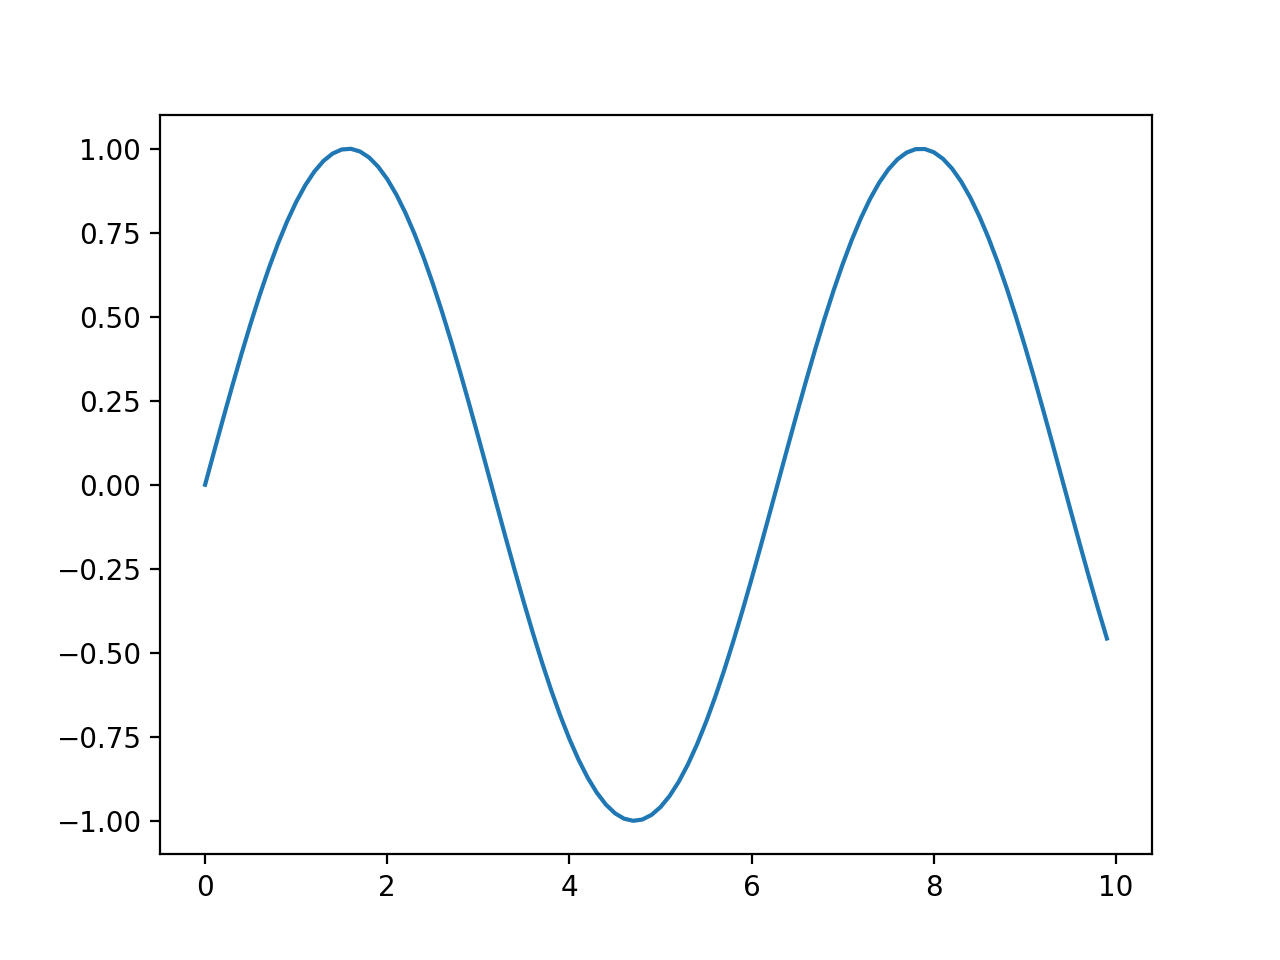

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
import numpy as np
print(matplotlib.get_backend())
x = np.arange(0, 10, 0.1)
plt.plot(x, np.sin(x))